In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import config
from utils import compute_frames

In [2]:
import torch
from torch.utils.data import Dataset

In [3]:
dev = "cuda:0"

# History dataset generation

In [4]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [5]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [6]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [7]:
# counties
frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

In [8]:
# precipitations
precip = pd.read_csv(config.TR_RAIN_AVG)
precip["quarter_date"] = pd.to_datetime(precip["dt"])

In [9]:
# terrain position index
tpi = pd.read_csv(config.TR_TPI, skiprows=1)\
    .rename(columns={"Unnamed: 0": "frame_id"})

In [10]:
# land cover
landcover = pd.read_csv(config.TR_LANDCOVER)
landcover = pd.pivot_table(
    landcover, 
    index=["frame_id"], 
    columns=["landcover"], 
    values="geometry", 
    aggfunc="sum"
).fillna(0).astype(int)
# convert to percentage
sum_by_frame = landcover.sum(axis=1)
for col in landcover.columns:
    landcover[col] = landcover[col] / sum_by_frame

In [12]:
# past scores
past_scores = pd.read_csv(config.TR_PAST_SCORES)

## Create grid

In [13]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [14]:
time_grid.shape

(28, 1002, 778)

# Counties data

## Population and density

In [15]:
county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
county_data[0] = (
    frames_county.set_index("frame_id")["populacao"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

county_data[1] = (
    frames_county.set_index("frame_id")["densidade"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

## Deforestation

In [16]:
frames_counties_defor = pd.merge(
    counties_defor,
    frames_county[["frame_id", "county_id"]],
    on="county_id",
    how="right"
)
frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

In [17]:
# create limits history grid
counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    defor_area = (
        frames_counties_defor[
            frames_counties_defor["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:04,  6.84it/s]


In [18]:
counties_time_grid.shape

(28, 1002, 778)

# Precipitations

In [19]:
# create limits history grid
precip_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    precip_sum = (
        precip[
            precip["quarter_date"] == dt
        ].set_index("frame_id")["precipitation"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    precip_time_grid[t, :, :] = precip_sum.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:03,  8.34it/s]


In [20]:
precip_time_grid.shape

(28, 1002, 778)

# Terrain Position Index

In [21]:
cols = ["mean", "min", "max", "std"]
tpi_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for icol, col in enumerate(cols):
    v = (
        tpi.set_index("frame_id")[col] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    tpi_array[icol, :, :] = v.values.reshape(tpi_array[0, :, :].shape)

In [22]:
tpi_array.shape

(4, 1002, 778)

# Land Cover

In [23]:
landcover_categories = [[20], [40, 50], [180]]
landcover_array = np.zeros((len(landcover_categories), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for i, cols in enumerate(landcover_categories):
    v = (
        landcover[cols].sum(axis=1) +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    landcover_array[i, :, :] = v.values.reshape(landcover_array[0, :, :].shape)

In [24]:
landcover_array.shape

(3, 1002, 778)

# Past scores

In [26]:
# create history grid for scores
scores_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    t_scores = (
        past_scores[
            past_scores["variable"] == dt
        ].set_index("frame_id")["value"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    scores_time_grid[t, :, :] = t_scores.values.reshape(scores_time_grid[0, :, :].shape)

28it [00:02, 10.48it/s]


In [27]:
scores_time_grid.shape

(28, 1002, 778)

# Compute frame patches

A patch is squared set of unitary frames. The patch formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [28]:
out_condition = "both"  # deforestation | borders | both

bundle_step = 32
patches = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                patches.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain some deforestation
                patches.append(iframes.index) 

        elif out_condition == "both":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if (out_of_borders_frames < len(iframes)) and (iframes["in_borders"].mean() >= 0.5):
                patches.append(iframes.index) 

100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


In [29]:
# remove patches that represent reduced regions
patches = [b for b in patches if (len(b)==len(patches[0]))]

In [30]:
len(patches)

431

In [31]:
patches[0]

Index([  288,   289,   290,   291,   292,   293,   294,   295,   296,   297,
       ...
       49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365],
      dtype='int64', length=4096)

In [32]:
# generate region and check which patches intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 200, 300, 500, 600)

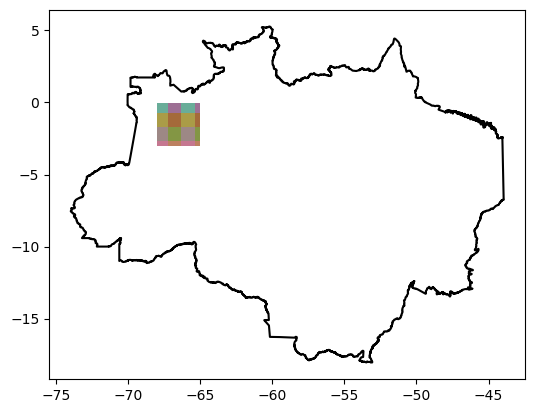

In [33]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
j = 0
for i, b in enumerate(patches):
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.plot(ax=ax, color=sns.color_palette()[j%10], alpha=.5)
        j+=1
        if j > 30:
            break
plt.show()

# Train test split

In [34]:
time_grid.shape

(28, 1002, 778)

In [35]:
train_time_idx = range(0,12)
val_time_idx = range(12,20)
test_time_idx = range(20,28)

train_data = time_grid[train_time_idx, :, :]
val_data = time_grid[val_time_idx, :, :]
test_data = time_grid[test_time_idx, :, :]

# Data Normalization

In [36]:
one_multiplicator_factor = (train_data <= 1e-7).sum() / (train_data > 1e-7).sum()

In [37]:
norm_pop = (county_data[0, :, :] - np.median(county_data[0, :, :])) / 1e5
norm_den = (county_data[1, :, :] - np.median(county_data[1, :, :])) / 30

county_data[0, :, :] = norm_pop
county_data[1, :, :] = norm_den

In [38]:
counties_time_grid = (counties_time_grid-counties_time_grid[train_time_idx, :, :].mean()) / counties_time_grid[train_time_idx, :, :].std()

In [39]:
precip_time_grid = (precip_time_grid-precip_time_grid[train_time_idx, :, :].mean()) / precip_time_grid[train_time_idx, :, :].std()

In [40]:
for i in range(tpi_array.shape[0]):
    tpi_array[i, :, :] = (tpi_array[i, :, :] - tpi_array[i, :, :].mean()) / tpi_array[i, :, :].std()

# Loss function

In [41]:
def WeightedBinaryCrossEntropy(target, prediction):
    return -(target*prediction.log() + (1-target)*((1-prediction).log()))

In [42]:
import torch.nn as nn

ce_loss = nn.CrossEntropyLoss().to(dev)

# Dataset & Dataloaders

In [43]:
len(patches) * (time_grid.shape[0] - 4)

10344

In [50]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X, 
        patches, 
        frames_idx, 
        county_data=None, 
        county_defor=None,
        precip_data=None,
        tpi_data=None,
        landcover_data=None,
        scores_data=None
    ):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.county_defor = county_defor
        self.precip_data = precip_data
        self.tpi_data = tpi_data
        self.landcover_data = landcover_data
        self.scores_data = scores_data

        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        input_matrix = self.X[
            idx_time:idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]

        if self.county_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.county_defor is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_defor[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.precip_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.precip_data[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.tpi_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.tpi_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.landcover_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.landcover_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.scores_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.scores_data[
                    [idx_time+self.autor_window],
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        data = torch.tensor(input_matrix).float().to(dev)

        # get output
        labels = np.zeros(
            (
                2, 
                idx_frames["x"].max()-idx_frames["x"].min() + 1, 
                idx_frames["y"].max()-idx_frames["y"].min() + 1
            )
        )
        target_idx = np.where(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ] > 1e-7
        )
        labels[0, :, :] = 1
        labels[0, :, :][target_idx] = 0
        labels[1, :, :][target_idx] = 1
        labels = torch.tensor(labels).float().to(dev)
        return data, labels

In [51]:
train_data.shape, val_data.shape, test_data.shape

((12, 1002, 778), (8, 1002, 778), (8, 1002, 778))

In [52]:
# patches_sample_train = [patches[i] for i in np.random.choice(range(len(patches)), 100, replace=False)]
# patches_sample_test = [patches[i] for i in np.random.choice(range(len(patches)), 10, replace=False)]

# patches_sample_train = patches[:1]
# patches_sample_test = patches[1:2]

patches_sample_train = patches
patches_sample_val = patches

In [53]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches_sample_train, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid
    ),
    batch_size=40,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches_sample_val, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid
    ),
    batch_size=1000,
    shuffle=False
)

In [54]:
trainloader.__len__(), valloader.__len__()

(87, 2)

# Baseline Model

Evaluate error without any model

In [55]:
# baseline: all 50%
base_train_err = 0
for inputs, labels in trainloader:
    y_pred = torch.tensor(np.zeros(labels.shape)).to(dev)
    y_pred[:, 0, :, :] = 1
    base_train_err += ce_loss(input=y_pred, target=labels)
base_train_err = base_train_err / len(trainloader)

print(f"Baseline Error (Train) = {base_train_err:.6f}")

Baseline Error (Train) = 0.329706


In [56]:
base_val_err = 0
for inputs, labels in valloader:
    y_pred = torch.tensor(np.zeros(labels.shape)).to(dev)
    y_pred[:, 0, :, :] = 1
    base_val_err += ce_loss(input=y_pred, target=labels)
base_val_err = base_val_err / len(valloader)
print(f"Baseline Error (Validation) = {base_val_err:.6f}")

Baseline Error (Validation) = 0.336113


# Model Init

In [57]:
import torch.optim as optim
import segmentation_models_pytorch as smp

In [64]:
in_channels = 4+2+4+4+4+3+1
in_channels

22

In [65]:
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=in_channels,
    classes=2,
)
optimizer = optim.Adam(model.parameters())

In [66]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    in_channels=in_channels, 
    classes=2
)
optimizer = optim.Adam(model.parameters())

In [67]:
# use gpu
model = model.to(dev)

In [68]:
# model.load_state_dict(torch.load(r"basic_cnn_003.pt"))

In [69]:
print(model)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(22, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [70]:
# check for inifinty error
train_err = 0
for inputs, labels in trainloader:
    y_pred = model(inputs).detach().to(dev)
    train_err += ce_loss(input=y_pred, target=labels)
    # train_err += WeightedBinaryCrossEntropy(labels, y_pred).detach().float().mean()
    print(train_err)
    if train_err > 1e9:
        break

tensor(1.0439, device='cuda:0')
tensor(2.0857, device='cuda:0')
tensor(3.1407, device='cuda:0')
tensor(4.1873, device='cuda:0')
tensor(5.2268, device='cuda:0')
tensor(6.2784, device='cuda:0')
tensor(7.3276, device='cuda:0')
tensor(8.3789, device='cuda:0')
tensor(9.4256, device='cuda:0')
tensor(10.4705, device='cuda:0')
tensor(11.5154, device='cuda:0')
tensor(12.5533, device='cuda:0')
tensor(13.5977, device='cuda:0')
tensor(14.6244, device='cuda:0')
tensor(15.6653, device='cuda:0')
tensor(16.7060, device='cuda:0')
tensor(17.7452, device='cuda:0')
tensor(18.7931, device='cuda:0')
tensor(19.8434, device='cuda:0')
tensor(20.8851, device='cuda:0')
tensor(21.9268, device='cuda:0')
tensor(22.9742, device='cuda:0')
tensor(24.0190, device='cuda:0')
tensor(25.0583, device='cuda:0')
tensor(26.0920, device='cuda:0')
tensor(27.1409, device='cuda:0')
tensor(28.1796, device='cuda:0')
tensor(29.2306, device='cuda:0')
tensor(30.2767, device='cuda:0')
tensor(31.3188, device='cuda:0')
tensor(32.3621, dev

Train loop

In [71]:
# train loop
model.epoch = 0
model.errs = []

In [72]:
def evaluate_model(model, dataloader):
    err = 0
    for inputs, labels in dataloader:
        y_pred = model(inputs).detach()
        err += ce_loss(input=y_pred, target=labels)
    err = err / len(dataloader)

    return err

In [73]:
def run_epoch():
    model.epoch += 1
    print(f"\nEpoch {model.epoch}")
    
    train_err = 0
    for inputs, labels in tqdm(trainloader):
        y_pred = model(inputs)
        loss = ce_loss(input=y_pred, target=labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_err += loss.detach()
    train_err = train_err / len(trainloader)
    
    return train_err


def train(n_epochs):
    for epoch in range(n_epochs):
        
        # train for 1 epoch and compute error
        train_err = run_epoch()

        # compute validation error and save history            
        val_err = evaluate_model(model, valloader)
        model.errs.append([train_err, val_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Validation Loss = {val_err:.6f}")

In [74]:
train(50)


Epoch 1


100%|██████████| 87/87 [00:13<00:00,  6.44it/s]


Epoch 1: Train Loss = 0.137621 | Validation Loss = 0.104979

Epoch 2


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 2: Train Loss = 0.078051 | Validation Loss = 0.102479

Epoch 3


100%|██████████| 87/87 [00:13<00:00,  6.39it/s]


Epoch 3: Train Loss = 0.075296 | Validation Loss = 0.099331

Epoch 4


100%|██████████| 87/87 [00:13<00:00,  6.37it/s]


Epoch 4: Train Loss = 0.073420 | Validation Loss = 0.098266

Epoch 5


100%|██████████| 87/87 [00:13<00:00,  6.33it/s]


Epoch 5: Train Loss = 0.072272 | Validation Loss = 0.100010

Epoch 6


100%|██████████| 87/87 [00:13<00:00,  6.29it/s]


Epoch 6: Train Loss = 0.071895 | Validation Loss = 0.099449

Epoch 7


100%|██████████| 87/87 [00:13<00:00,  6.35it/s]


Epoch 7: Train Loss = 0.071186 | Validation Loss = 0.094820

Epoch 8


100%|██████████| 87/87 [00:13<00:00,  6.44it/s]


Epoch 8: Train Loss = 0.069655 | Validation Loss = 0.097113

Epoch 9


100%|██████████| 87/87 [00:13<00:00,  6.44it/s]


Epoch 9: Train Loss = 0.068493 | Validation Loss = 0.089883

Epoch 10


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch 10: Train Loss = 0.068609 | Validation Loss = 0.087162

Epoch 11


100%|██████████| 87/87 [00:13<00:00,  6.31it/s]


Epoch 11: Train Loss = 0.070097 | Validation Loss = 0.093309

Epoch 12


100%|██████████| 87/87 [00:13<00:00,  6.41it/s]


Epoch 12: Train Loss = 0.067199 | Validation Loss = 0.086780

Epoch 13


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch 13: Train Loss = 0.065119 | Validation Loss = 0.085910

Epoch 14


100%|██████████| 87/87 [00:13<00:00,  6.39it/s]


Epoch 14: Train Loss = 0.065449 | Validation Loss = 0.084382

Epoch 15


100%|██████████| 87/87 [00:13<00:00,  6.51it/s]


Epoch 15: Train Loss = 0.064762 | Validation Loss = 0.086389

Epoch 16


100%|██████████| 87/87 [00:13<00:00,  6.42it/s]


Epoch 16: Train Loss = 0.064887 | Validation Loss = 0.087713

Epoch 17


100%|██████████| 87/87 [00:13<00:00,  6.59it/s]


Epoch 17: Train Loss = 0.064126 | Validation Loss = 0.088300

Epoch 18


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch 18: Train Loss = 0.063113 | Validation Loss = 0.085522

Epoch 19


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch 19: Train Loss = 0.062179 | Validation Loss = 0.084121

Epoch 20


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 20: Train Loss = 0.062550 | Validation Loss = 0.089309

Epoch 21


100%|██████████| 87/87 [00:13<00:00,  6.56it/s]


Epoch 21: Train Loss = 0.061832 | Validation Loss = 0.087024

Epoch 22


100%|██████████| 87/87 [00:13<00:00,  6.50it/s]


Epoch 22: Train Loss = 0.059862 | Validation Loss = 0.086961

Epoch 23


100%|██████████| 87/87 [00:13<00:00,  6.42it/s]


Epoch 23: Train Loss = 0.059332 | Validation Loss = 0.083118

Epoch 24


100%|██████████| 87/87 [00:13<00:00,  6.36it/s]


Epoch 24: Train Loss = 0.059692 | Validation Loss = 0.087737

Epoch 25


100%|██████████| 87/87 [00:13<00:00,  6.54it/s]


Epoch 25: Train Loss = 0.065230 | Validation Loss = 0.086968

Epoch 26


100%|██████████| 87/87 [00:13<00:00,  6.52it/s]


Epoch 26: Train Loss = 0.061436 | Validation Loss = 0.083211

Epoch 27


100%|██████████| 87/87 [00:13<00:00,  6.49it/s]


Epoch 27: Train Loss = 0.059122 | Validation Loss = 0.084597

Epoch 28


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch 28: Train Loss = 0.058762 | Validation Loss = 0.084439

Epoch 29


100%|██████████| 87/87 [00:13<00:00,  6.40it/s]


Epoch 29: Train Loss = 0.058536 | Validation Loss = 0.085122

Epoch 30


100%|██████████| 87/87 [00:13<00:00,  6.54it/s]


Epoch 30: Train Loss = 0.056922 | Validation Loss = 0.084089

Epoch 31


100%|██████████| 87/87 [00:13<00:00,  6.51it/s]


Epoch 31: Train Loss = 0.056353 | Validation Loss = 0.086536

Epoch 32


100%|██████████| 87/87 [00:13<00:00,  6.55it/s]


Epoch 32: Train Loss = 0.056850 | Validation Loss = 0.084062

Epoch 33


100%|██████████| 87/87 [00:13<00:00,  6.54it/s]


Epoch 33: Train Loss = 0.056292 | Validation Loss = 0.084815

Epoch 34


100%|██████████| 87/87 [00:13<00:00,  6.48it/s]


Epoch 34: Train Loss = 0.055045 | Validation Loss = 0.084363

Epoch 35


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 35: Train Loss = 0.054614 | Validation Loss = 0.085211

Epoch 36


100%|██████████| 87/87 [00:13<00:00,  6.46it/s]


Epoch 36: Train Loss = 0.054267 | Validation Loss = 0.083501

Epoch 37


100%|██████████| 87/87 [00:13<00:00,  6.54it/s]


Epoch 37: Train Loss = 0.053603 | Validation Loss = 0.087593

Epoch 38


100%|██████████| 87/87 [00:13<00:00,  6.51it/s]


Epoch 38: Train Loss = 0.053180 | Validation Loss = 0.083792

Epoch 39


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 39: Train Loss = 0.053271 | Validation Loss = 0.087728

Epoch 40


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 40: Train Loss = 0.052447 | Validation Loss = 0.085096

Epoch 41


100%|██████████| 87/87 [00:13<00:00,  6.61it/s]


Epoch 41: Train Loss = 0.051920 | Validation Loss = 0.085392

Epoch 42


100%|██████████| 87/87 [00:13<00:00,  6.55it/s]


Epoch 42: Train Loss = 0.051176 | Validation Loss = 0.088398

Epoch 43


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 43: Train Loss = 0.050989 | Validation Loss = 0.089414

Epoch 44


100%|██████████| 87/87 [00:13<00:00,  6.50it/s]


Epoch 44: Train Loss = 0.050719 | Validation Loss = 0.084788

Epoch 45


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]


Epoch 45: Train Loss = 0.050468 | Validation Loss = 0.086603

Epoch 46


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Epoch 46: Train Loss = 0.049631 | Validation Loss = 0.087186

Epoch 47


100%|██████████| 87/87 [00:13<00:00,  6.39it/s]


Epoch 47: Train Loss = 0.050041 | Validation Loss = 0.087513

Epoch 48


100%|██████████| 87/87 [00:13<00:00,  6.31it/s]


Epoch 48: Train Loss = 0.050168 | Validation Loss = 0.088526

Epoch 49


100%|██████████| 87/87 [00:14<00:00,  6.17it/s]


Epoch 49: Train Loss = 0.049716 | Validation Loss = 0.087080

Epoch 50


100%|██████████| 87/87 [00:13<00:00,  6.24it/s]


Epoch 50: Train Loss = 0.049558 | Validation Loss = 0.087990


Better than baseline?

In [75]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_val_err)
)

(-0.2801481939105758, -0.24812351389524312)

Learning curve

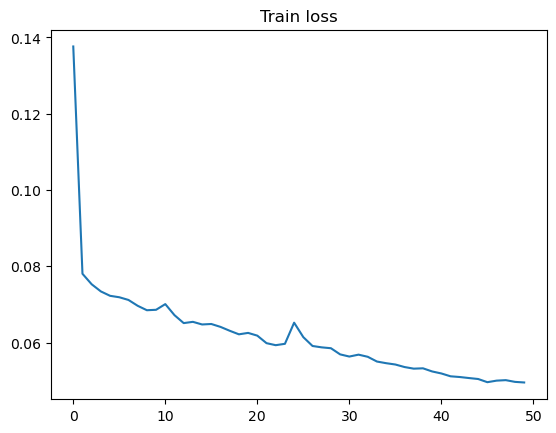

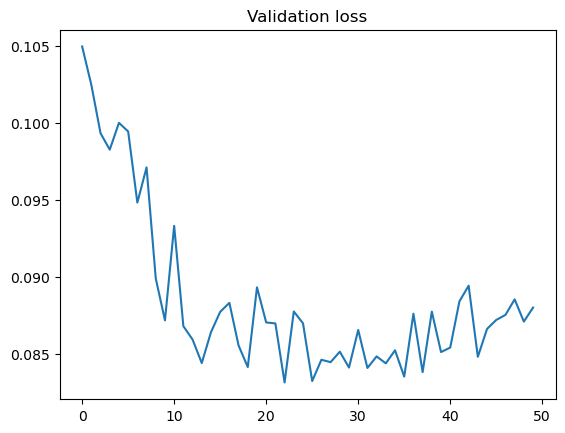

In [76]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.title("Train loss")
plt.show()
plt.plot([float(e[1]) for e in model.errs])
plt.title("Validation loss")
plt.show()

Prediction example

In [77]:
softmax_ = nn.Softmax(dim=1)

In [91]:
def get_sample(min_area=0.1):
    for input_, truth in valloader:
        for idx_batch in range(truth.shape[0]):
            if truth[idx_batch, 1, :, :].mean() > min_area:
                return input_, truth, idx_batch

In [92]:
input_, truth, idx_batch = get_sample(0.01)

pred = model(input_)

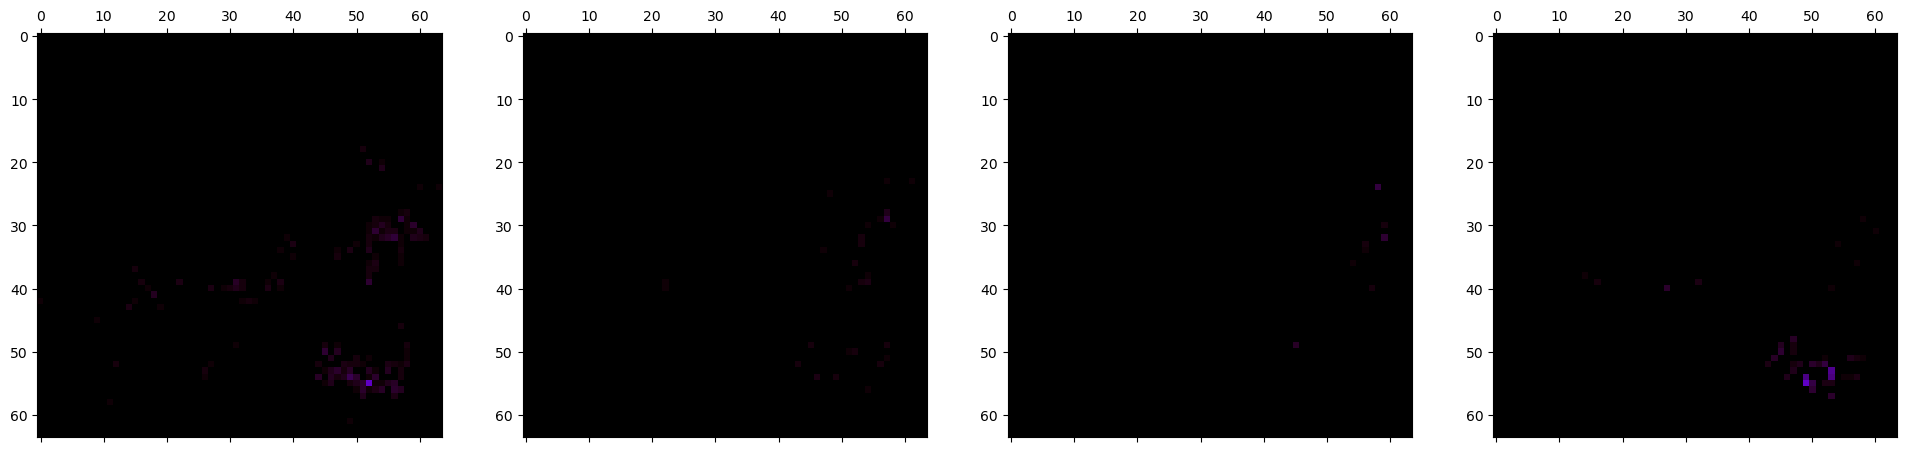

In [93]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(4):
    ax[i].matshow(input_[idx_batch, i, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
plt.show()

C:\Users\giovanni\AppData\Local\Temp\ipykernel_2768\3523613288.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


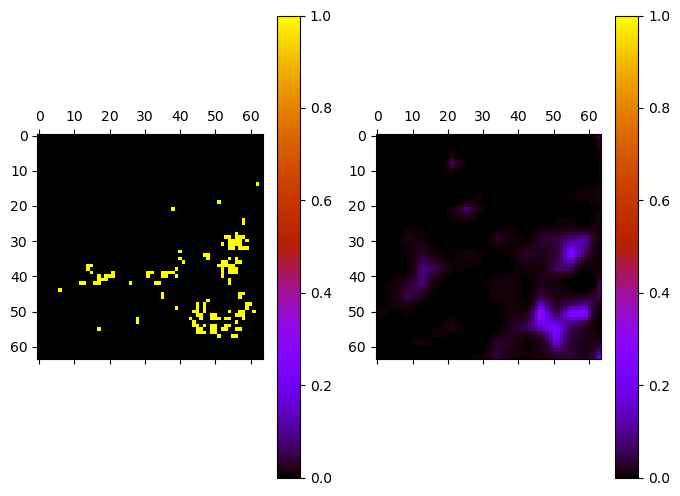

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
m1 = ax[0].matshow(truth[idx_batch, 1, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
m2 = ax[1].matshow(softmax_(pred).detach().cpu().numpy()[idx_batch, 1, :, :], cmap="gnuplot", vmin=truth.min(), vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.show()

# Save model

In [ ]:
torch.save(model.state_dict(), r"DeepLabV3+.pt")